In [3]:
# Fundamental packages for data handling and array manipulations
import os
import time
import random
import numpy as np
import pandas as pd

# Image processing and computer vision libraries
from PIL import Image, ImageOps, ImageFilter
import cv2
from glob import glob

# Machine learning and deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, EfficientNetB7, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import cluster, metrics, preprocessing, decomposition
from sklearn.model_selection import train_test_split

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from plot_keras_history import show_history, plot_history

# Settings and seeds for reproducibility
%matplotlib inline
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


Le 1er traitement m'a indiqué que l'image Computers27.jpg est corrompue.   
Elle correspond à l'image : 9743e6d1c9f3180483825fe4d2e97836.  
Je l'ai supprimée de mon stock d'images. Je vais aussi la supprimer du dataframe

# 1 - Préparation

## 1.1 - Lecture du dataframe d'images

In [4]:
df=pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...

In [5]:
indices_to_drop = df[df['image'] == '9743e6d1c9f3180483825fe4d2e97836.jpg'].index
df = df.drop(indices_to_drop)

In [6]:
df.shape

(1049, 15)

In [7]:
# Réindexation du dataframe sinon erreur + tard dans le code
df = df.reset_index(drop=True)

## 1.2 - Extraction de la target

In [8]:
df.product_category_tree.value_counts(normalize=True)

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         0.053384
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           0.024786
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  0.021926
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         0.020972
["Home Furnishing >> Bath Linen >> Towels"]                                           0.018112
                                                                                        ...   
["Computers >> Network Components >> Routers >> Linksys Routers"]                     0.000953
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]       0.000953
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]    0.000953
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]       0.000953
["Watches >> Wrist Watches >

In [9]:
# Fonction pour extraire les niveaux de catégorie
def extract_category_levels(category_tree):
    levels = category_tree.split(" >> ")
    category_level_1 = levels[0]
    category_level_2 = levels[1] if len(levels) > 1 else ""
    category_level_3 = levels[2] if len(levels) > 2 else ""
    
    return category_level_1, category_level_2, category_level_3

In [10]:
category_levels = df.product_category_tree.apply(extract_category_levels)

In [11]:
# Assignation des résultats à de nouvelles variables
category_level_1 = category_levels.apply(lambda x: x[0])
category_level_2 = category_levels.apply(lambda x: x[1])
category_level_3 = category_levels.apply(lambda x: x[2])

In [12]:
df['label']=category_level_1

In [13]:
# Suppression des caractères [" dans la colonne 'category_level_1'
df['label'] = df['label'].str.replace(r'\["', '', regex=True)

In [14]:
df=df[['image', 'label']]
df.head()

image            label
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing

## 1.3 - Renommage des photos

### 1.3.1 - Dans le dataframe

In [15]:
def rename_images(df):
    # Dictionnaire pour garder la trace des compteurs pour chaque label
    counters = {}
    
    # Fonction pour créer le nouveau nom d'image
    def create_new_image_name(row):
        label = row['label'].replace(" ", "_")  # Remplace les espaces par des underscores
        # Remplace '&' par 'and'
        label = label.replace("&", "and")
        # Initialise le compteur pour ce label s'il n'existe pas déjà
        counters[label] = counters.get(label, 0) + 1
        # Forme le nouveau nom de l'image
        new_image_name = f"{label}{counters[label]}.jpg"
        return new_image_name
    
    # Applique la fonction pour créer un nouveau nom d'image à chaque ligne
    df['new_name_image'] = df.apply(create_new_image_name, axis=1)
    return df

In [16]:
df = rename_images(df)
df.sample(10)

image                       label  \
352  b5b47b2ecf5cf5760051b0a980ed7a3f.jpg                   Computers   
985  c3c23b5aa5e388e5f71883f61d1a0561.jpg  Home Decor & Festive Needs   
877  dc777afc918f513a7253187e00a11948.jpg             Home Furnishing   
983  357432a848c3f13fa614efe5dddd99b6.jpg  Home Decor & Festive Needs   
31   29b1ca231e10d5269516b80bf9d0dffc.jpg                     Watches   
448  49f7763dc9c7ece284a1ae27166f8c6c.jpg                   Baby Care   
198  d75705ad163412347cba51f882e9c0f0.jpg  Home Decor & Festive Needs   
424  60a7313ea1e0ee8d845a0a6dec6117cc.jpg                   Computers   
107  b515014adccb1fdf5ff1e2c4a8ff9ea6.jpg             Home Furnishing   
713  6acca991d2353781779b866e4f96edd9.jpg             Home Furnishing   

                          new_name_image  
352                      Computers33.jpg  
985  Home_Decor_and_Festive_Needs144.jpg  
877                Home_Furnishing99.jpg  
983  Home_Decor_and_Festive_Needs143.jpg  
31                         Watches27.jpg  
448                      Baby_Care35.jpg  
198   Home_Decor_and_Festive_Needs26.jpg  
424                      Computers59.jpg  
107                Home_Furnishing16.jpg  
713                Home_Furnishing55.jpg

In [17]:
df.groupby("label").count()

image  new_name_image
label                                            
Baby Care                     150             150
Beauty and Personal Care      150             150
Computers                     149             149
Home Decor & Festive Needs    150             150
Home Furnishing               150             150
Kitchen & Dining              150             150
Watches                       150             150

In [18]:
# Renommage des lables
correspondence_dict = {
    'Baby Care': 'Baby_Care',
    'Beauty and Personal Care': 'Beauty_and_Personal_Care',
    'Computers': 'Computers',
    'Home Decor & Festive Needs': 'Home_Decor_and_Festive_Needs',
    'Home Furnishing': 'Home_Furnishing',
    'Kitchen & Dining': 'Kitchen_and_Dining',
    'Watches': 'Watches'
}

df['label'] = df['label'].replace(correspondence_dict)


In [19]:
df.head()

image            label        new_name_image
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home_Furnishing  Home_Furnishing1.jpg
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby_Care        Baby_Care1.jpg
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby_Care        Baby_Care2.jpg
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home_Furnishing  Home_Furnishing2.jpg
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home_Furnishing  Home_Furnishing3.jpg

In [20]:
df.groupby("label").count()

image  new_name_image
label                                              
Baby_Care                       150             150
Beauty_and_Personal_Care        150             150
Computers                       149             149
Home_Decor_and_Festive_Needs    150             150
Home_Furnishing                 150             150
Kitchen_and_Dining              150             150
Watches                         150             150

### 1.3.2 - Dans le dossier des photos enregistrées sur mon PC

In [21]:
# for index, row in df.iterrows():
#     nom_actuel = row['image']
#     nouveau_nom = row['new_name_image']
#     chemin_actuel = os.path.join(path, nom_actuel)
#     nouveau_chemin = os.path.join(path, nouveau_nom)
    
#     # Vérifie si le fichier existe avant de le renommer
#     if os.path.isfile(chemin_actuel):
#         os.rename(chemin_actuel, nouveau_chemin)
#     else:
#         print(f"Le fichier {nom_actuel} n'a pas été trouvé.")

# 2 - Préparation de la classification supervisée

## 2.1 - Création d'un dataframe contenant le path de chaque photo + son label

In [22]:
path = r"C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images"
path

'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images'

In [24]:
data_path = glob(path+'*/*.jp*')
data_path

['C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care1.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care10.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care100.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care101.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care102.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care103.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care104.jpg',
 'C:\\Users\\belou\\Projet 6\\nouveau_projet\\Dataset_prétraitement_textes_images\\Images\\list_images\\Baby_Care105.jpg',
 'C:\\Users

In [25]:
list_labels=df['label'].unique().tolist()
list_labels

['Home_Furnishing',
 'Baby_Care',
 'Watches',
 'Home_Decor_and_Festive_Needs',
 'Kitchen_and_Dining',
 'Beauty_and_Personal_Care',
 'Computers']

In [26]:
label_no_name = "no_name "

In [27]:
def photo_class(photo) :
    for label in list_labels :
        if label in photo : 
            return label
    return label_no_name

In [28]:
def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

In [29]:
data = data_fct(data_path)

1049


In [30]:
pd.set_option('display.max_colwidth', None)

In [31]:
data.sample(10)

image_path  \
893            C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Kitchen_and_Dining94.jpg   
361                      C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Computers2.jpg   
569  C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Home_Decor_and_Festive_Needs72.jpg   
297      C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Beauty_and_Personal_Care97.jpg   
196     C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Beauty_and_Personal_Care140.jpg   
251      C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Beauty_and_Personal_Care55.jpg   
635              C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Home_Furnishing131.jpg   
35                     C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care130.jpg   
82                      C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care38.jpg   
714               C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Home_Furnishing68.jpg   

                       label_name  
893            Kitchen_and_Dining  
361                     Computers  
569  Home_Decor_and_Festive_Needs  
297      Beauty_and_Personal_Care  
196      Beauty_and_Personal_Care  
251      Beauty_and_Personal_Care  
635               Home_Furnishing  
35                      Baby_Care  
82                      Baby_Care  
714               Home_Furnishing

In [32]:
data['label_name'].unique().tolist()

['Baby_Care',
 'Beauty_and_Personal_Care',
 'Computers',
 'Home_Decor_and_Festive_Needs',
 'Home_Furnishing',
 'Kitchen_and_Dining',
 'Watches']

In [33]:
df['label'].unique().tolist()

['Home_Furnishing',
 'Baby_Care',
 'Watches',
 'Home_Decor_and_Festive_Needs',
 'Kitchen_and_Dining',
 'Beauty_and_Personal_Care',
 'Computers']

## 2.2 - Création d'un set de test

In [34]:
data.head()

image_path  \
0    C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care1.jpg   
1   C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care10.jpg   
2  C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care100.jpg   
3  C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care101.jpg   
4  C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care102.jpg   

  label_name  
0  Baby_Care  
1  Baby_Care  
2  Baby_Care  
3  Baby_Care  
4  Baby_Care

In [35]:
data.shape

(1049, 2)

In [36]:
# Mélange du dataframe
data_shuffled = data.sample(frac=1, random_state=42)  

# Calcul de l'index pour la séparation
split_idx = int(0.7 * len(data_shuffled))

# Division en train et test
data = data_shuffled[:split_idx]
data_test = data_shuffled[split_idx:]

In [37]:
data.shape, data_test.shape

((734, 2), (315, 2))

## 2.3 - Encodage de la target

In [38]:
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])
# data.head(5)
data_test.head(5)

C:\Users\belou\AppData\Local\Temp\ipykernel_31872\3004557233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = le.transform(data["label_name"])
C:\Users\belou\AppData\Local\Temp\ipykernel_31872\3004557233.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["label"] = le.transform(data_test["label_name"])


image_path  \
908            C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Watches107.jpg   
820  C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Kitchen_and_Dining28.jpg   
8            C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care106.jpg   
868  C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Kitchen_and_Dining71.jpg   
36           C:\Users\belou\Projet 6\nouveau_projet\Dataset_prétraitement_textes_images\Images\list_images\Baby_Care131.jpg   

             label_name  label  
908             Watches      6  
820  Kitchen_and_Dining      5  
8             Baby_Care      0  
868  Kitchen_and_Dining      5  
36            Baby_Care      0

## 2.4 - Préparation des images

In [39]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

Construction d'une fonction pour que l'ordinateur apprenne à reconnaître les images par lui-même en regardant ces photos et en se souvenant de leurs étiquettes.

In [40]:
batch_size = 32 #  définit le nombre de photos à traiter à la fois par l'ordinateur

def data_flow_fct(data, # les données qui contiennent les photos et leurs étiquettes
                  datagen, # outil pour transformer les photos
                  data_type=None) : # poss de spécifier si l'on traite des données d'entraînement ou de test, mais par défaut il n'est pas spécifié
    data_flow = datagen.flow_from_dataframe(data, # utilisation de datagen pour créer un "flux de données" => comment elle va donner les photos à l'ordinateur.
                                            directory='', # indique que les photos sont déjà dans le DataFrame et qu'il n'y a pas besoin de spécifier un dossier où les trouver.
                                            x_col='image_path', #  spécifie le nom de la colonne dans data où les chemins des photos sont stockés.
                                            y_col='label_name', # indique le nom de la colonne où les étiquettes des photos sont stockées.
                                            weight_col=None, # signifie qu'aucune colonne de poids n'est utilisée (parfois utilisée pour donner plus d'importance à certaines photos).
                                            target_size=(224, 224),
                                            classes=None, # laisse l'outil décider automatiquement des classes à partir des étiquettes fournies.
                                            class_mode='categorical', # configure le type de classification
                                            batch_size=batch_size, 
                                            shuffle=True, # mélange les photos pour que l'ordre de présentation soit différent à chaque fois, ce qui aide l'ordinateur à mieux apprendre.
                                            seed=42,
                                            subset=data_type #  permet de spécifier si les données utilisées sont pour l'entraînement ou pour le test.
                                )
    return data_flow

Configuration pour augmenter automatiquement les données d'images de plusieurs façons.   
J'ai relancé le notebook plusieurs fois en testant chaque transformation une par une, puis toutes ensemble. J'ai récupéré les scores à chaque fois pour comparer. Le meilleur scoe est obtenu avec le décalage horizontal aléatoire :

In [41]:
datagen_train = ImageDataGenerator( # Instance de Keras, utilisée pour augmenter les données d'image pour le deep learning) :
    
    # rotation_range=20, # Cette option permet de faire tourner les images de manière aléatoire pendant l'entraînement. 
    #                     # Le chiffre "20" signifie que l'image peut être tournée de -20 à +20 degrés. 
    #                    
    
    width_shift_range=0.2, # Permet de décaler les images horizontalement de manière aléatoire. 
                            # Le chiffre "0.2" signifie que les images peuvent être déplacées jusqu'à 20% de leur largeur. 

    
    
    # height_shift_range=0.2, # Similaire au paramètre précédent, mais pour un déplacement vertical. 
    #                         # Les images peuvent être déplacées jusqu'à 20% de leur hauteur. 
    #                        
    
    # horizontal_flip=True, #  Cette option permet de retourner les images horizontalement (comme un miroir). 
    #                     

    # shear_range=0.15,  # Cisaillement aléatoire jusqu'à 15%
    
    # zoom_range=0.2,  # Zoom aléatoire de l'image jusqu'à 20%

    # brightness_range = [0.5, 1.5], Fait varier la luminosité

    # channel_shift_range=20.0, les valeurs de chaque canal de couleur (RVB) peuvent être augmentées ou diminuées aléatoirement jusqu'à 20 unités.
    
    validation_split=0.25, # Utilisé pour réserver 25% des données pour la validation.
    
    preprocessing_function=preprocess_input) # Cette fonction est appliquée à chaque image avant qu'elle ne soit passée au réseau de neurones. 
                                             # preprocess_input est souvent spécifique à un modèle particulier 
                                             # et est conçue pour préparer les images de manière appropriée pour le modèle

In [42]:
train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

Found 551 validated image filenames belonging to 7 classes.
Found 183 validated image filenames belonging to 7 classes.


In [43]:
datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

In [44]:
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 315 validated image filenames belonging to 7 classes.


In [45]:
test_flow

## 2.7 Création du modèle de classification

In [46]:
def create_model_fct():
    # Récupération modèle pré-entraîné, sans les couches fully-connected
    model_base = EfficientNetB7(include_top=False, # La suppression des dernières couches se fait en ajoutant l'argument  include_top = False  
                                          # lors de l'import du modèle pré-entraîné. 
                                          # Dans ce cas, il faut aussi préciser les dimensions des images en entrée (input_shape ) 
                                weights="imagenet", 
                                input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False # on ne ré-entraîne pas les autres couches (on garde les poids du modèle pré-entraîné)

    # Récupération de la sortie de ce réseau
    x = model_base.output
    
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x) # réduction des dimensions spatiales de la sortie à un vecteur unique par carte de caractéristiques, 
                                    # pour condenser l'information tout en réduisant la complexité et le surapprentissage.
    x = Dense(256, activation='relu')(x) #  Ajout d'une couche dense avec 256 unités et fonction d'activation ReLU, 
    x = Dropout(0.5)(x) # suivie d'une couche Dropout(0.5) pour aider à réduire le surapprentissage en "désactivant" 
                        # aléatoirement 50% des nœuds pendant l'entraînement.
    predictions = Dense(7, activation='softmax')(x) # Classification en 7 classes, avec la fonction d'activation softmax 
                                                    # pour la sortie de probabilités de classe.

    # Définition du nouveau modèle
    model = Model(inputs=model_base.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", 
                  optimizer='rmsprop', 
                  metrics=["accuracy"])
    return model


In [47]:
# Création du modèle
with tf.device('/gpu:0'):  
    model2 = create_model_fct()

In [48]:
# Création du callback
model2_save_path = "./model2_best_weights.keras"      

Le ModelCheckpoint est un outil qui permet de sauvegarder automatiquement le modèle pendant son entraînement, mais seulement lorsqu'il s'améliore selon un critère spécifique (val_loss ici, qui représente l'erreur du modèle sur un ensemble de validation) :

In [49]:
checkpoint = ModelCheckpoint(model2_save_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min') 


EarlyStopping est un autre outil qui arrête l'entraînement du modèle si celui-ci ne s'améliore plus pendant un certain nombre d'itérations (patience=5), pour éviter de perdre du temps et des ressources si le modèle ne progresse plus :

In [50]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=3)


Création de la liste de callbacks définis précédemment (Model CheckPoint et Early Stopping) :

In [51]:
callbacks_list = [checkpoint, es]

In [52]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2.8 - Entrainement du modèle sur les données fournies :

In [53]:
start_time = time.time()

with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                          validation_data=val_flow,
                          batch_size=batch_size, 
                          epochs=50, 
                          callbacks=callbacks_list,
                          verbose=1)

end_time = time.time()

execution_time = end_time - start_time
print("Le temps d'exécution est :", execution_time, "secondes")

Epoch 1/50


C:\Users\belou\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/18 ━━━━━━━━━━━━━━━━━━━━ 11s 729ms/step - accuracy: 0.2348 - loss: 1.7251

C:\Users\belou\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6001 - loss: 1.1518
Epoch 1: val_loss improved from inf to 0.56537, saving model to ./model2_best_weights.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.6070 - loss: 1.1384 - val_accuracy: 0.8251 - val_loss: 0.5654
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8894 - loss: 0.3963
Epoch 2: val_loss improved from 0.56537 to 0.52375, saving model to ./model2_best_weights.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.8894 - loss: 0.3949 - val_accuracy: 0.8415 - val_loss: 0.5237
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9172 - loss: 0.2731
Epoch 3: val_loss did not improve from 0.52375
18/18 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9173 - loss: 0.2725 - val_accuracy: 0.8743 - val_loss: 0.5311
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9602 - loss: 0.1815
Epoch 4: val_loss improved from 0.52375 to 0.50071, saving model to ./model2_best_weights.keras
18

## 2.9 - Moyenne accuracy sur tous les lots de l'Epoch Optimal

Le code ci-dessous charge les meilleurs poids sauvegardés dans le modèle model1. Ces poids correspondent à ceux du modèle ayant atteint la meilleure performance sur l'ensemble de validation (en termes de perte de validation) durant l'entraînement, grâce au callback ModelCheckpoint. Cela permet de restaurer le modèle à son état optimal tel qu'évalué durant l'entraînement.

In [54]:
# Chargement du meilleur modèle sauvegardé
model2.load_weights(model2_save_path)

In [55]:
# Évaluation sur l'ensemble d'entraînement
train_loss, train_accuracy = model2.evaluate(train_flow)
print("Accuracy d'entraînement: {:.2f}%".format(train_accuracy * 100))

18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9896 - loss: 0.0780
Accuracy d'entraînement: 98.37%


Évaluation du modèle chargé (avec les meilleurs poids) sur l'ensemble de validation.  
Cette opération calcule la perte et l'exactitude du modèle sur ces données :

In [56]:
val_loss, val_accuracy = model2.evaluate(val_flow)
print("Accuracy de validation: {:.2f}%".format(val_accuracy * 100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8878 - loss: 0.4591
Accuracy de validation: 87.43%


Evaluation du modèle sur un ensemble de test. L'ensemble de test est utilisé pour mesurer la capacité du modèle à généraliser sur des données totalement nouvelles et non utilisées pendant l'entraînement ni la validation :

In [57]:
test_loss, test_accuracy = model2.evaluate(test_flow)
print("Accuracy de test: {:.2f}%".format(test_accuracy * 100))

10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8850 - loss: 0.3807
Accuracy de test: 87.94%


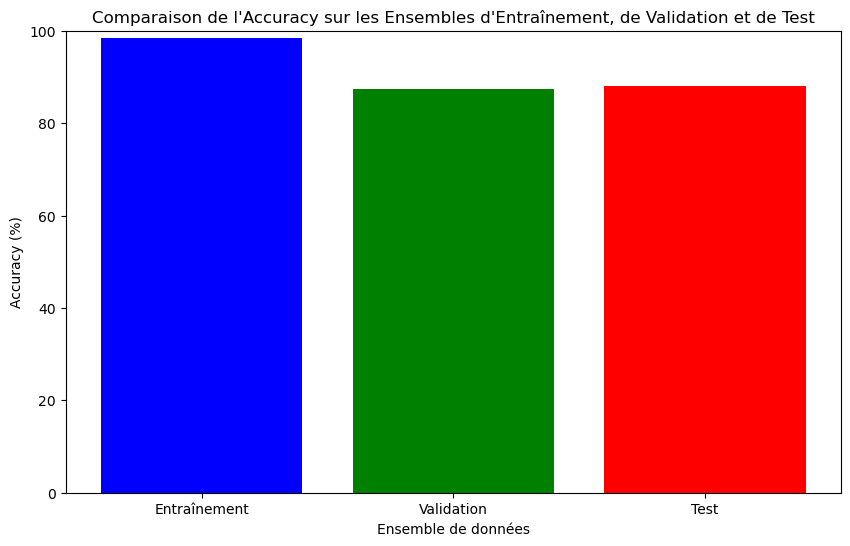

In [58]:
accuracies = [train_accuracy * 100, val_accuracy * 100, test_accuracy * 100]
labels = ['Entraînement', 'Validation', 'Test']

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Ensemble de données')
plt.ylabel('Accuracy (%)')
plt.title('Comparaison de l\'Accuracy sur les Ensembles d\'Entraînement, de Validation et de Test')
plt.ylim([0, 100])  # pour une échelle de pourcentage
plt.show()

## 2.10 - Affichage de l'accuracy et de la perte pour chaque Epoch

Affichage de l'accuracy et de la perte pour chaque Epoch, à la fois pour les ensembles d'entraînement et de validation :

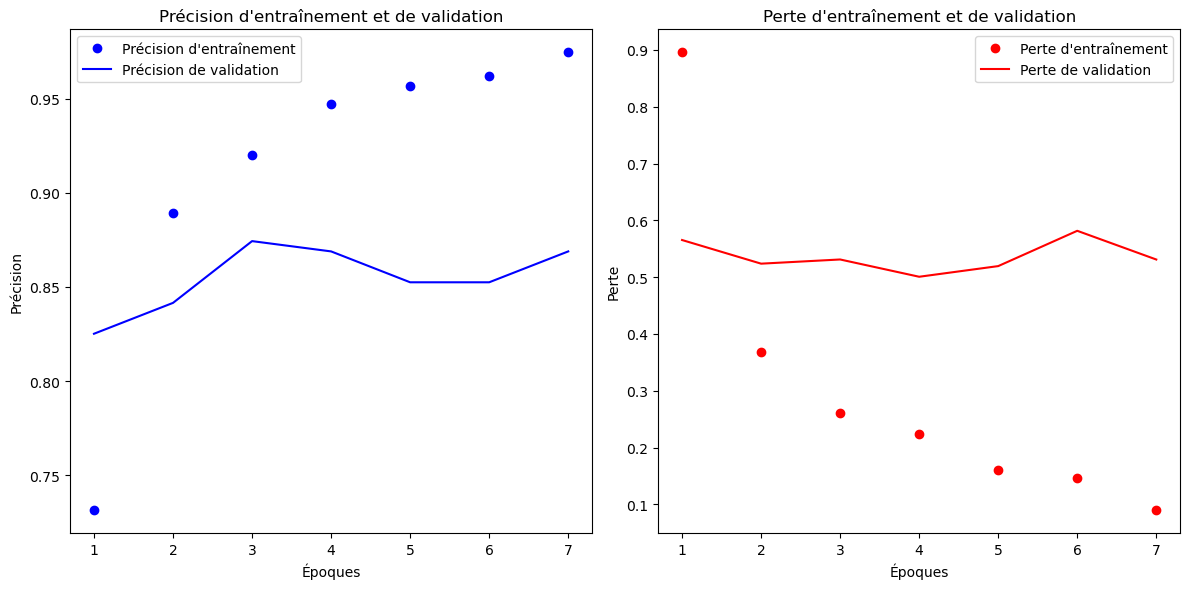

In [59]:
# Récupération des données d'historique
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

# Tracé de la précision
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Précision d\'entraînement')
plt.plot(epochs, val_acc, 'b', label='Précision de validation')
plt.title('Précision d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracé de la perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()